#### Requirements 

In [1]:
# !pip install tensorflow 
# !pip install numpy 
# !pip install pandas
# !pip install matplotlib
# !pip install scikit-learn
# !pip install seaborn


#### GPU usage for tf

In [2]:
!nvidia-smi # veriying if NVIDEA drive and CUDA runtime loads 

Mon Jun 30 17:03:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060        Off |   00000000:01:00.0  On |                  N/A |
| 33%   32C    P5             N/A /  115W |     634MiB /   8188MiB |      7%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# 1) Ver todas as GPUs
gpus = tf.config.list_physical_devices("GPU")
print("GPUs detectadas:", gpus)

if gpus:
    # 2) (Opcional) limitar a visão só à primeira GPU
    tf.config.set_visible_devices(gpus[0], "GPU")

    # 3) (Recomendado) liberar memória sob demanda
    tf.config.experimental.set_memory_growth(gpus[0], True)

2025-06-30 17:03:35.119781: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-30 17:03:35.120083: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-30 17:03:35.122088: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-30 17:03:35.127239: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751313815.136214 1219039 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751313815.13

GPUs detectadas: []


E0000 00:00:1751313816.470486 1219039 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1751313816.470711 1219039 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


#### Other libs

In [17]:
# LIBS

import os
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
from pandas.plotting import register_matplotlib_converters
# import statsmodels.api as sm
# from pmdarima import auto_arima
#bibliotecas usadas no gridserach
from sklearn.model_selection import TimeSeriesSplit
import keras

register_matplotlib_converters()
sns.set_style("darkgrid")

plt.rc("figure", figsize=(16, 6))
plt.rc("font", size=13)

from matplotlib.pyplot import figure

figure(figsize = (16, 6), dpi = 100)

<Figure size 1600x600 with 0 Axes>

<Figure size 1600x600 with 0 Axes>

#### Model improvement

In [5]:
#gridsearch
def grid_search_cv(modelo, units, X_train, learning_rates, y_train, epochs_list, batch_sizes, patiences, model_name):
    best_loss = float('inf')
    best_params = {}
    for lr in learning_rates:
        for epochs in epochs_list:
            for batch_size in batch_sizes:
                for patience in patiences:
                    model = modelo(units, X_train, lr)
                    histories = fit_model_with_cross_validation(model, X_train, y_train, model_name, patience, epochs, batch_size)
                    mean_history = calculate_mean_history(histories)
                    val_loss = min(mean_history['val_loss'])
                    print("Val Loss: ", val_loss, "learning rate: ", lr, "epochs: ",  epochs, "batch_size: " , batch_size, "patience: ", patience)
                    if val_loss < best_loss:
                        best_loss = val_loss
                        best_params = {'learning_rate': lr, 'epochs': epochs, 'batch_size': batch_size, 'patience': patience} 
    print('O modelo '+model_name+ ' tem como melhores parametros os seguintes: learning_rate '+ str(best_params['learning_rate'])+' epochs: '+ str(best_params['epochs'])+' batch_size: '+ str(best_params['batch_size'])+ ' patience: '+ str(best_params['patience']))
    return best_params

#validação cruzada
def fit_model_with_cross_validation(model, xtrain, ytrain, model_name, patience, epochs, batch_size):
    tscv = TimeSeriesSplit(n_splits=5)
    fold = 1
    histories = []
    for train_index, val_index in tscv.split(xtrain):
        x_train_fold, x_val_fold = xtrain[train_index], xtrain[val_index]
        y_train_fold, y_val_fold = ytrain[train_index], ytrain[val_index]
        early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, min_delta=1e-5)
        history = model.fit(x_train_fold, y_train_fold, epochs=epochs, validation_data=(x_val_fold, y_val_fold), batch_size=batch_size, callbacks=[early_stop], verbose=1)
        print('\n\nTREINAMENTO - Fold', fold, 'do modelo:', model_name)
        histories.append(history)
        fold += 1   
    return histories 

# calcula a media das metricas obtidas nos historys - validação cruzada
def calculate_mean_history(histories):
    mean_history = {'loss': [], 'root_mean_squared_error': [], 'val_loss': [], 'val_root_mean_squared_error': []}
    for fold_history in histories:
        for key in mean_history.keys():
            mean_history[key].append(fold_history.history[key])
    for key, values in mean_history.items():
        max_len = max(len(val) for val in values)
        for i in range(len(values)):
            if len(values[i]) < max_len: #caso em que nao se treina todas as epocas (patience)
                values[i] += [values[i][-1]] * (max_len - len(values[i])) #completa o restante da lista com o ultimo valor obtido
    for key, values in mean_history.items():
        mean_history[key] = [sum(vals) / len(vals) for vals in zip(*values)]
    
    return mean_history


#### LSTM construction

In [6]:
# Main functions

# Create input dataset
# The input shape should be [samples, time steps, features
def create_dataset (X, look_back = 3):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
        
    return np.array(Xs), np.array(ys)

# Create LSTM model
def create_lstm(units, train, learning_rate): 
    model = Sequential() 
    # Old Config
    model.add(LSTM(units = units, return_sequences = True, input_shape = [train.shape[1], train.shape[2]]))
    model.add(LSTM(units = units)) 
    # model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss=MeanSquaredError(), optimizer = Adam(learning_rate=learning_rate), metrics=[RootMeanSquaredError()])
    
    return model

#treinamento do modelo
def fit_model(model, xtrain, ytrain, model_name, patience, epochs, batch_size ):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = patience, restore_best_weights=True)
    history = model.fit(xtrain, ytrain, epochs = epochs, validation_split = 0.2, batch_size = batch_size, shuffle = False, callbacks=[early_stop]) 
    print('\n\nTREINAMENTO: ' + model_name)
    return history

# Make prediction
def prediction(model, xtest, ytest, myscaler, model_name, link): 
    prediction = model.predict(xtest) 
    prediction = myscaler.inverse_transform(prediction) 
    # dataframe_prediction = pd.DataFrame(data={'Predições':prediction.flatten()})
    dataframe_prediction = pd.DataFrame(data={'Prediction':prediction.flatten(), 'Test':ytest.flatten()})
    #save_path = os.path.join('..', '..', 'predicoes', f'prediction {model_name} {link}.csv') 
    save_path = os.path.join('..', '..', 'results', 'bi-lstm', 'forecast', f'prediction {model_name} {link}.csv') 
    dataframe_prediction.to_csv(save_path)
    return prediction


# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    nrmse = rmse/ ((np.max(actual))-(np.min(actual)))
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('Normalized Root Mean Square Error: {:.4f}%'.format(nrmse*100))
    print('')

    return rmse, mae, nrmse, model_name




#### Utils

In [7]:
def bits_para_megabits(df, col_vaz):
    # Dados em MegaBits/s e fill
    df[col_vaz] = df[col_vaz]/1000000
    df[col_vaz] = df[col_vaz].replace(-1, df[col_vaz].mean())
    df[col_vaz] = df[col_vaz].fillna(df[col_vaz].mean())

    return df


#### Plots and visualizations

In [8]:
                
def visualizacao_series(df, col_vazao, titulo):
    df[col_vazao].plot(figsize=(18,6))
    plt.title(titulo)
    plt.ylabel('Vazao (Mbits/s)')
    plt.legend() 
    plt.show()

#plotar os graficos da media dos treinamentos por epocas: validação cruzada
def plot_loss_cv(mean_history, model_name, link):
    epochs = range(1, len(mean_history['loss']) + 1)
    plt.plot(epochs, mean_history['loss'], label='Train Loss')
    plt.plot(epochs, mean_history['val_loss'], label='Validation Loss')
    plt.title('Mean Training and Validation Loss for '+' '+link + ' '+ model_name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_rmse_cv(mean_history):
    epochs = range(1, len(mean_history['root_mean_squared_error']) + 1)
    plt.plot(epochs, mean_history['root_mean_squared_error'], label='Train RMSE')
    plt.plot(epochs, mean_history['val_root_mean_squared_error'], label='Validation RMSE')
    plt.title('Mean Training and Validation RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

########################################### plote dos graficos de treinamento ###################################################################################
 #Plot train loss and validation loss
def plot_loss(history, model_name, link):
     plt.figure(figsize = (15, 6), dpi=100)
     plt.plot(history.history['loss'])
     plt.plot(history.history['val_loss'])
     plt.title('Model Train vs Validation Loss for '+' '+link + ' '+ model_name)
     plt.ylabel('Loss')
     plt.xlabel('Epoch')
     plt.legend(['Train loss', 'Validation loss'], loc='upper right')
def plot_rmse(history, model_name, link):
     plt.figure(figsize = (15, 6), dpi=100)
     plt.plot(history.history['rmse'])
     plt.plot(history.history['val_rmse'])
     plt.title('Model Train vs RMSE for '+' '+link + ' '+ model_name)
     plt.ylabel('rmse')
     plt.xlabel('Epoch')
     plt.legend(['Train rmse', 'Validation loss'], loc='upper right')
################################################################################################################################################################
 

def plot_future(predictionLSTM, y_test, link):
    plt.figure(figsize=(15, 6), dpi=100)
    range_future = len(y_test)
    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(predictionLSTM), label='LSTM')
    # dict_to_dataframe_prediction = {
    #     # "range_future": np.arange(range_future),
    #     f"prediction{model_name}": np.array(prediction.squeeze())
    # }
    
    plt.title('Test data vs prediction for '+ link)
    plt.legend(loc='upper left')
    plt.xlabel('Time')
    plt.ylabel('Mbis/s')
    save_path = os.path.join('..', '..', 'results', 'bi-lstm', 'plots', link + '.png')
    save_path = os.path.normpath(save_path)  

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    try:
        plt.savefig(save_path)
        print(f"A figura foi salva com sucesso em: {save_path}")
    except Exception as e:
        print(f"Erro ao salvar a figura: {e}")
    plt.show()

    # #Tenta salvar a fig
    # save_path = os.path.join('..', '..', 'graficos', 'predicoes', 'round_2', 'graficos', link + '.png')

    # #save_path = '../../graficos/predicoes/round_2/graficos/' + link + '.png'
    # try:
    #     plt.savefig(save_path)
    #     print(f"A figura foi salva com sucesso em: {save_path}")
    # except Exception as e:
    #     print(f"Erro ao salvar a figura: {e}")

    # plt.show()


# Plot test data vs prediction
# def plot_future(predictionGRU, predictionLSTM, y_test, link):
#     plt.figure(figsize=(15, 6), dpi=100)
#     range_future = len(y_test)
#     plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
#     plt.plot(np.arange(range_future), np.array(predictionGRU), label='GRU')
#     plt.plot(np.arange(range_future), np.array(predictionLSTM), label='LSTM')
#     # dict_to_dataframe_prediction = {
#     #     # "range_future": np.arange(range_future),
#     #     f"prediction{model_name}": np.array(prediction.squeeze())
#     # }
    
#     plt.title('Test data vs prediction for '+ link)
#     plt.legend(loc='upper left')
#     plt.xlabel('Time')
#     plt.ylabel('Mbis/s')

#     #Tenta salvar a fig
#     save_path = '../../graficos/predicoes/round_2/graficos/' + link + '.png'
#     try:
#         plt.savefig(save_path)
#         print(f"A figura foi salva com sucesso em: {save_path}")
#     except Exception as e:
#         print(f"Erro ao salvar a figura: {e}")

#     plt.show()
    

#### Data manipulation

##### Paths

In [9]:
# Paths
TRAINING_OUTPUT = os.path.join('training_output.txt')
THROUGHPUT_DATASETS = os.path.join('..', '..', 'datasets', 'test-recursive-lstm')
MODEL = os.path.join("..", "..", 'modelo_salvo')
METRICS = os.path.join('..', '..', 'results', 'bi-lstm', 'evaluation_rmse_mae_2.json')

In [10]:
#função para salvar o modelo
def save_model(model, directory, substring_desejada, modelo):
    if not os.path.exists(directory):
        os.makedirs(directory)
    file_path = os.path.join(directory, f'{substring_desejada +modelo} - final_model.keras')
    model.save(file_path)
    print(f"Modelo salvo como '{file_path}'")

### Main
#### Model training and predcition 

##### Organized original

In [11]:

# # Redirecionar saída padrão para um arquivo com codificação utf-8
# orig_stdout = sys.stdout
# f = open(TRAINING_OUTPUT, 'w', encoding='utf-8')
# sys.stdout = f

# #treinamento e predição
# # Defina o diretório raiz onde deseja iniciar a busca
# diretorio_raiz = TRAINING_OUTPUT

# evaluation = {}

# # Itere pelos diretórios e subdiretórios
# for pasta_raiz, subpastas, arquivos in os.walk(diretorio_raiz):
#     for arquivo in arquivos:
#         if arquivo.endswith('.csv'):
#             # Construa o caminho completo para o arquivo
#             caminho_arquivo = os.path.join(pasta_raiz, arquivo)

#         try:
#                 # Título parser
#                 # partes = caminho_arquivo.split("\\")
#                 # if len(partes) >= 2:
#                 # #     substring_desejada = "/".join(partes[1:])  # Acesse as partes a partir da segunda e as una com barras invertidas
#                 partes = caminho_arquivo.split(os.sep)
#                 #partes = caminho_arquivo.split("/")
#                 substring_desejada = partes[4] + ' - ' + partes[5]  # Acesse as partes a partir da segunda e as una com barras invertidas

#                 df = pd.read_csv(caminho_arquivo, index_col='Timestamp')
#                 if '0' in df.columns:
#                     df = df.drop('0', axis=1)
                
#                 # Regularizar o dataset para megabits/s
#                 bits_para_megabits(df, 'Throughput')

#                 # Visualização das séries
#                 # visualizacao_series(df, 'Vazao', substring_desejada)

#                 print('###################### '+substring_desejada+' ##########################')

#                 #####################################################
#                 ########                   FORECASTING            ###
#                 #####################################################

#                 tf.random.set_seed(7)
                
#                 # *********** acho que vou ter que fazer uma máscara de valores faltantes **********
#                 # Split train data and test data
#                 tamanho = int(len(df.index) * 0.8) 
#                 train_size = tamanho

#                 # train_data = df.WC.loc[:train_size] -----> it gives a series
#                 # Do not forget use iloc to select a number of rows
#                 train_data = df[:train_size]
#                 test_data = df[train_size:]
                
#                 # Criar uma instância do MinMaxScaler
#                 train_data = train_data['Throughput'].values.reshape(-1, 1) # reshape serve para deixar claro que cada timestamp tem uma variável observada (throughput)
#                 test_data = test_data['Throughput'].values.reshape(-1, 1)

#                 scaler = MinMaxScaler().fit(train_data)

#                 train_scaled = scaler.transform(train_data)
#                 test_scaled = scaler.transform(test_data)

#                 # ******* acho que aqui vou adicionar um loop para mover a janela ************
#                 X_train, y_train = create_dataset(train_scaled)
#                 X_test, y_test = create_dataset(test_scaled)

#                 #grid search para encontrar os melhores parametros
#                 list_lr = [0.00001] # learning rate, não muda
#                 list_epochs = [100, 300, 500] # épocas
#                 list_bs = [32, 64, 128] # bash (lotes)
#                 list_pat = [5] # patiente para early stopping

#                 caminho_modelo_salvo = MODEL
#                 best_params_lstm = grid_search_cv(create_lstm, 64, X_train, list_lr, y_train, list_epochs, list_bs, list_pat, 'lstm')
#                 #tendo os melhores parametros, eu crio o modelo e treino ele com os melhores
#                 model_lstm = create_lstm(64, X_train, best_params_lstm['learning_rate'])

#                 prev_history_lstm = fit_model_with_cross_validation(model_lstm, X_train, y_train, 'lstm', best_params_lstm['patience'], best_params_lstm['epochs'], best_params_lstm['batch_size'])
#                 history_lstm = calculate_mean_history(prev_history_lstm)
                
#                 #salvando o modelo
#                 save_model(model_lstm, caminho_modelo_salvo, substring_desejada, 'LSTM')

#                 # Transform data back to original data space
#                 y_test = scaler.inverse_transform(y_test)
#                 y_train = scaler.inverse_transform(y_train)

#                 prediction_lstm = prediction(model_lstm, X_test, y_test, scaler, 'LSTM', link=substring_desejada)
                
#                 plot_loss_cv(history_lstm, 'LSTM', substring_desejada)
                
#                 plot_future(prediction_lstm, y_test, link = substring_desejada)
#                 # lstm_forecast = plot_future(prediction_lstm, 'LSTM', y_test, link = substring_desejada)

#                 # plot_future_comparing_train_test (X_train, prediction_gru[1], 'GRU', substring_desejada)
#                 # plot_future_comparing_train_test (X_train, prediction_lstm[1], 'LSTM', substring_desejada)
#                 lstm_evaluation = evaluate_prediction(prediction_lstm, y_test, 'LSTM')

#                 chave_lstm = f"{substring_desejada}, {lstm_evaluation[3]}"  # Crie uma chave baseada no valor de i
#                 tupla = (lstm_evaluation[0], lstm_evaluation[1], lstm_evaluation[2])  # Crie uma tupla com valores baseados em i
#                 evaluation[chave_lstm] = tupla  # Adicione a chave e a tupla ao dicionário

#                 # print(evaluation+'\n\n')
                    
#         except pd.errors.EmptyDataError:
#             # Arquivo vazio
#             print(f"Arquivo: {arquivo} - O arquivo está vazio, subpasta: {pasta_raiz}")
#         except Exception as e:
#             # Tratar outras exceções, se necessário
#                 print(f"Arquivo: {arquivo}, subpasta: {pasta_raiz} - Erro: {str(e)}")

    
#         novo_dicionario = {}
#         import json
        
#         # Itere pelo dicionário original
#         for chave, valores in evaluation.items():
#             valor1, valor2, valor3 = valores  # Desempacote os valores da tupla
#             novo_dicionario[chave] = {'RMSE': valor1, 'MAE': valor2, 'NRMSE': valor3}

#         json_path = METRICS
#         with open(json_path, 'w') as arquivo:
#             json.dump(novo_dicionario, arquivo, indent=4)

#         # with open('../../graficos/predicoes/round_2/evaluation_rmse_mae_2.json', 'w') as arquivo:
#         #     json.dump(novo_dicionario, arquivo, indent=4)

#     # with open('..\\..\\graficos\\predicoes\\round_2\\evaluation_rmse_mae_2.json', 'w') as arquivo:
#     #     json.dump(novo_dicionario, arquivo, indent=4)

#### Funtional with part of new solution

In [12]:
# # Redirecionar saída padrão para um arquivo com codificação utf-8
# orig_stdout = sys.stdout
# f = open(TRAINING_OUTPUT, 'w', encoding='utf-8')
# sys.stdout = f

# #treinamento e predição
# # Defina o diretório raiz onde deseja iniciar a busca
# diretorio_raiz = THROUGHPUT_DATASETS

# evaluation = {}

# # Itere pelos diretórios e subdiretórios
# for pasta_raiz, subpastas, arquivos in os.walk(diretorio_raiz):
#     for arquivo in arquivos:
#         if arquivo.endswith('.csv'):
#             # Construa o caminho completo para o arquivo
#             caminho_arquivo = os.path.join(pasta_raiz, arquivo)

#         try:
#                 # Título parser
#                 # partes = caminho_arquivo.split("\\")
#                 # if len(partes) >= 2:
#                 # #     substring_desejada = "/".join(partes[1:])  # Acesse as partes a partir da segunda e as una com barras invertidas
#                 partes = caminho_arquivo.split(os.sep)
#                 #partes = caminho_arquivo.split("/")
#                 substring_desejada = partes[4] + ' - ' + partes[5]  # Acesse as partes a partir da segunda e as una com barras invertidas

#                 df = pd.read_csv(caminho_arquivo, index_col='Timestamp')
#                 if '0' in df.columns:
#                     df = df.drop('0', axis=1)
                
#                 # Regularizar o dataset para megabits/s
#                 bits_para_megabits(df, 'Throughput')

#                 # Visualização das séries
#                 # visualizacao_series(df, 'Vazao', substring_desejada)

#                 print('###################### '+substring_desejada+' ##########################')

#                 #####################################################
#                 ########                   FORECASTING            ###
#                 #####################################################

#                 tf.random.set_seed(7)
                
#                 # *********** acho que vou ter que fazer uma máscara de valores faltantes **********
#                 # Split train data and test data
#                 tamanho = int(len(df.index) * 0.8) 
#                 train_size = tamanho

#                 # train_data = df.WC.loc[:train_size] -----> it gives a series
#                 # Do not forget use iloc to select a number of rows
#                 train_data = df[:train_size]
#                 test_data = df[train_size:]
                
#                 # Criar uma instância do MinMaxScaler
#                 train_data = train_data['Throughput'].values.reshape(-1, 1) # reshape serve para deixar claro que cada timestamp tem uma variável observada (throughput)
#                 test_data = test_data['Throughput'].values.reshape(-1, 1)

#                 scaler = MinMaxScaler().fit(train_data)

#                 train_scaled = scaler.transform(train_data)
#                 test_scaled = scaler.transform(test_data)

#                 # Preparar dados iniciais para treinamento
#                 X_train_original, y_train_original = create_dataset(train_scaled)

#                 #grid search para encontrar os melhores parametros (apenas uma vez)
#                 list_lr = [0.00001] # learning rate, não muda
#                 list_epochs = [100, 300, 500] # épocas
#                 list_bs = [32, 64, 128] # bash (lotes)
#                 list_pat = [5] # patiente para early stopping

#                 # teste de funcionamento
#                 # list_lr = [0.00001] # learning rate, não muda
#                 # list_epochs = [100] # épocas
#                 # list_bs = [32] # bash (lotes)
#                 # list_pat = [5] # patiente para early stopping

#                 caminho_modelo_salvo = MODEL
#                 best_params_lstm = grid_search_cv(create_lstm, 64, X_train_original, list_lr, y_train_original, list_epochs, list_bs, list_pat, 'lstm')

#                 # ******* IMPLEMENTAÇÃO DA JANELA DESLIZANTE ************
#                 janela_tamanho = 20  # Tamanho da janela ajustável
#                 num_clusters = len(test_scaled) // janela_tamanho
                
#                 # Lista para armazenar todas as predições
#                 todas_predicoes = []
                
#                 print(f"Processando {num_clusters} clusters de tamanho {janela_tamanho}")
                
#                 for cluster_idx in range(num_clusters):
#                     print(f"Processando cluster {cluster_idx + 1}/{num_clusters}")
                    
#                     # Definir início e fim do cluster atual
#                     inicio_cluster = cluster_idx * janela_tamanho
#                     fim_cluster = inicio_cluster + janela_tamanho
                    
#                     # Extrair o cluster atual dos dados de teste
#                     cluster_atual = test_scaled[inicio_cluster:fim_cluster]
                    
#                     # Criar novo conjunto de treinamento: treino_original[cluster_idx*janela_tamanho:] + clusters anteriores
#                     if cluster_idx == 0:
#                         # Primeiro cluster: usar apenas dados de treino originais
#                         novo_train_data = train_scaled
#                     else:
#                         # Clusters subsequentes: treino_original[inicio_cluster:] + clusters anteriores
#                         train_ajustado = train_scaled[inicio_cluster:]
#                         clusters_anteriores = test_scaled[:inicio_cluster]
#                         novo_train_data = np.vstack([train_ajustado, clusters_anteriores])
                    
#                     # Criar datasets para o modelo
#                     X_train_novo, y_train_novo = create_dataset(novo_train_data)
                    
#                     # Criar e treinar novo modelo para este cluster
#                     model_lstm_cluster = create_lstm(64, X_train_novo, best_params_lstm['learning_rate'])
                    
#                     # Treinar o modelo com os melhores parâmetros encontrados
#                     prev_history_lstm = fit_model_with_cross_validation(
#                         model_lstm_cluster, X_train_novo, y_train_novo, 'lstm', 
#                         best_params_lstm['patience'], best_params_lstm['epochs'], best_params_lstm['batch_size']
#                     )
                    
#                     # Preparar dados do cluster para predição
#                     X_cluster, y_cluster = create_dataset(cluster_atual)
                    
#                     # Fazer predição para o cluster atual
#                     if len(X_cluster) > 0:  # Verificar se há dados suficientes para predição
#                         predicao_cluster = model_lstm_cluster.predict(X_cluster)
#                         predicao_cluster = scaler.inverse_transform(predicao_cluster)
#                         todas_predicoes.append(predicao_cluster)
                        
#                         print(f"Cluster {cluster_idx + 1}: {len(predicao_cluster)} predições geradas")
#                     else:
#                         print(f"Cluster {cluster_idx + 1}: Dados insuficientes para predição")
                
#                 # Concatenar todas as predições
#                 if todas_predicoes:
#                     prediction_lstm_final = np.vstack(todas_predicoes)
                    
#                     # Preparar dados de teste para avaliação (apenas a parte que foi predita)
#                     test_data_avaliacao = test_scaled[:len(prediction_lstm_final)]
#                     X_test_final, y_test_final = create_dataset(test_data_avaliacao)
#                     y_test_final = scaler.inverse_transform(y_test_final)
                    
#                     # Ajustar tamanhos se necessário
#                     min_len = min(len(prediction_lstm_final), len(y_test_final))
#                     prediction_lstm_final = prediction_lstm_final[:min_len]
#                     y_test_final = y_test_final[:min_len]
                    
#                     print(f"Predição final: {len(prediction_lstm_final)} pontos")
                    
#                     # Salvar o último modelo treinado
#                     save_model(model_lstm_cluster, caminho_modelo_salvo, substring_desejada, 'LSTM')
                    
#                     # Transform data back to original data space para visualização
#                     y_train_viz = scaler.inverse_transform(y_train_original)
                    
#                     # Plotar resultados usando a última história de treinamento
#                     history_lstm = calculate_mean_history(prev_history_lstm)
#                     plot_loss_cv(history_lstm, 'LSTM', substring_desejada)
                    
#                     # Criar tupla compatível com plot_future (predição, dados_treino)
#                     prediction_tuple = (prediction_lstm_final, y_train_viz)
#                     # plot_future(prediction_tuple, y_test_final, link=substring_desejada)
                    
#                     # # Avaliar predição final
#                     # lstm_evaluation = evaluate_prediction(prediction_tuple, y_test_final, 'LSTM')

#                     plot_future(prediction_lstm_final, y_test_final, link=substring_desejada)
#                     lstm_evaluation = evaluate_prediction(prediction_lstm_final, y_test_final, 'LSTM')
                    
#                     chave_lstm = f"{substring_desejada}, {lstm_evaluation[3]}"
#                     tupla = (lstm_evaluation[0], lstm_evaluation[1], lstm_evaluation[2])
#                     evaluation[chave_lstm] = tupla
                    
#                     print(f"Avaliação final - RMSE: {lstm_evaluation[0]:.4f}, MAE: {lstm_evaluation[1]:.4f}, NRMSE: {lstm_evaluation[2]:.4f}")
                    
#                 else:
#                     print("Nenhuma predição foi gerada")
                    
#         except pd.errors.EmptyDataError:
#             # Arquivo vazio
#             print(f"Arquivo: {arquivo} - O arquivo está vazio, subpasta: {pasta_raiz}")
#         except Exception as e:
#             # Tratar outras exceções, se necessário
#                 print(f"Arquivo: {arquivo}, subpasta: {pasta_raiz} - Erro: {str(e)}")

    
#         novo_dicionario = {}
#         import json
        
#         # Itere pelo dicionário original
#         for chave, valores in evaluation.items():
#             valor1, valor2, valor3 = valores  # Desempacote os valores da tupla
#             novo_dicionario[chave] = {'RMSE': valor1, 'MAE': valor2, 'NRMSE': valor3}

#         json_path = METRICS
#         with open(json_path, 'w') as arquivo:
#             json.dump(novo_dicionario, arquivo, indent=4)

#         # with open('../../graficos/predicoes/round_2/evaluation_rmse_mae_2.json', 'w') as arquivo:
#         #     json.dump(novo_dicionario, arquivo, indent=4)

#     # with open('..\\..\\graficos\\predicoes\\round_2\\evaluation_rmse_mae_2.json', 'w') as arquivo:
#     #     json.dump(novo_dicionario, arquivo, indent=4)
# with open(METRICS, 'w', encoding='utf-8') as fp:
#     json.dump(
#         {k: {'RMSE': v[0], 'MAE': v[1], 'NRMSE': v[2]} for k, v in evaluation.items()},
#         fp, indent=4
#     )
# print(f"Arquivo de métricas salvo em {METRICS}")

/home/clara/Documentos/recursive-prediction/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/clara/Documentos/recursive-prediction/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/clara/Documentos/recursive-prediction/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/clara/Documentos/re

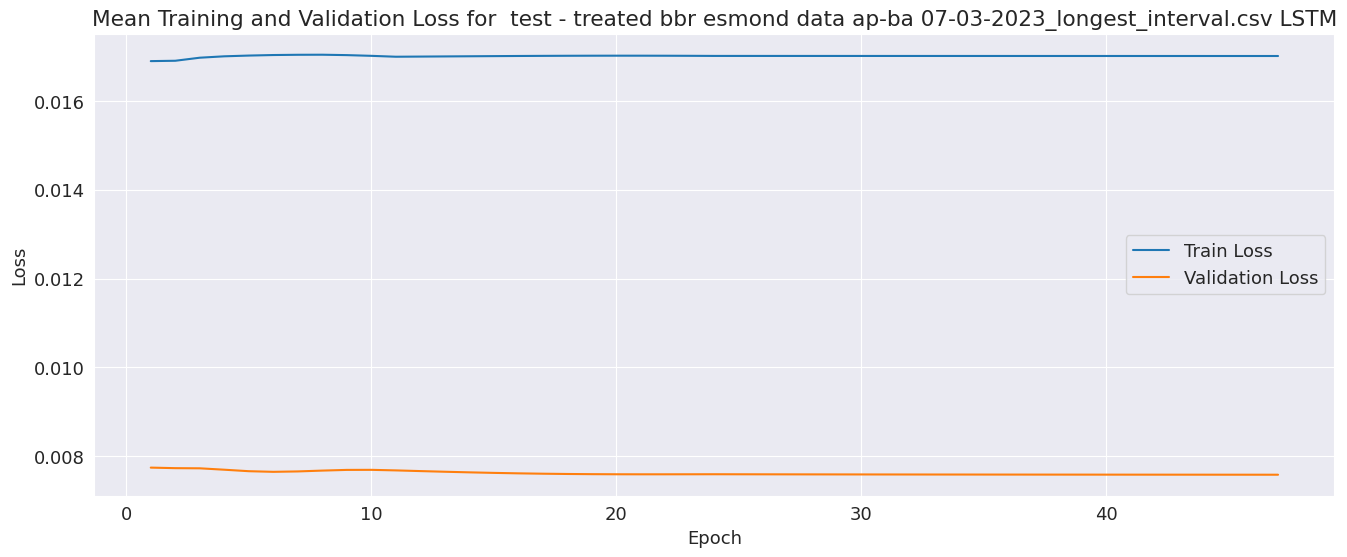

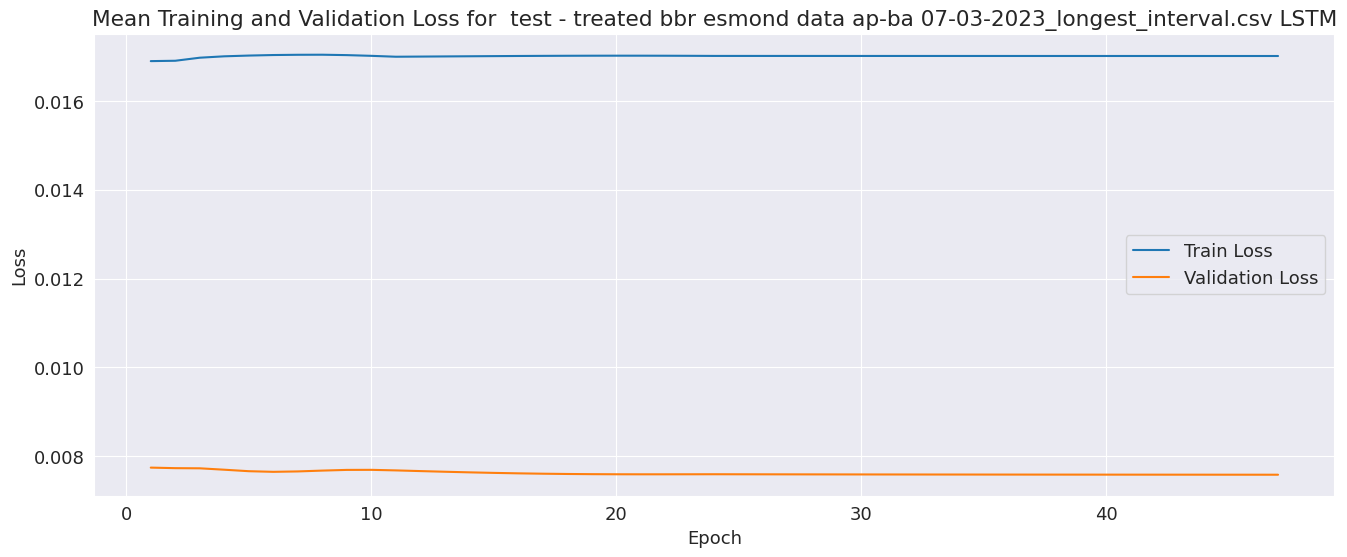

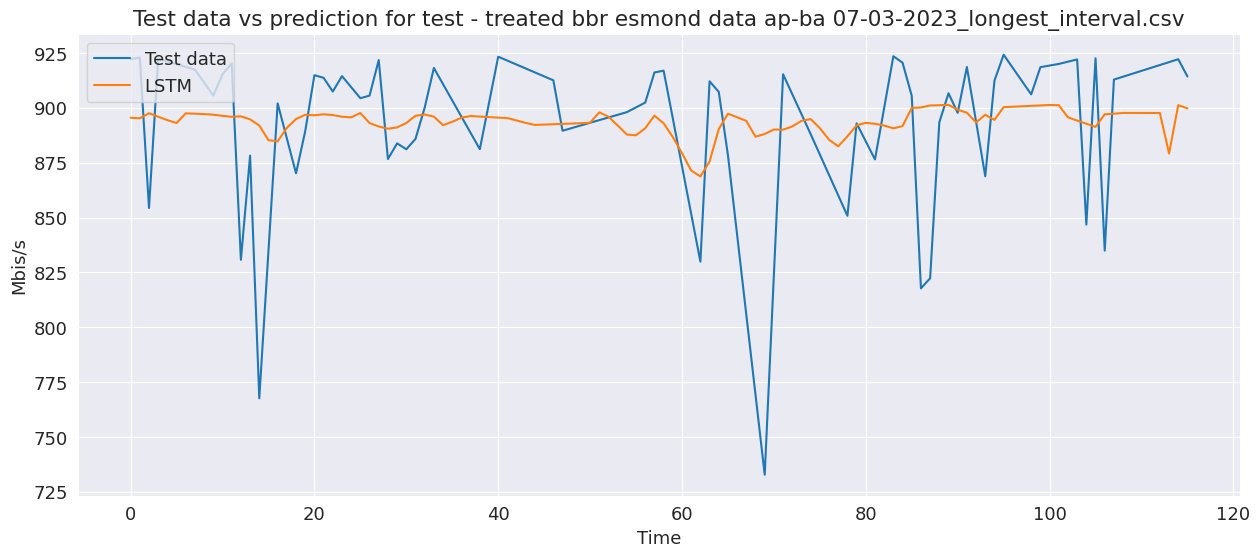

In [ ]:
# Redirecionar saída padrão para um arquivo com codificação utf-8
orig_stdout = sys.stdout
f = open(TRAINING_OUTPUT, 'w', encoding='utf-8')
sys.stdout = f

# Treinamento e predição
# Defina o diretório raiz onde deseja iniciar a busca
diretorio_raiz = THROUGHPUT_DATASETS

evaluation = {}

# Parâmetros atualizados conforme solicitado
list_lr = [1e-4, 5e-4, 1e-3]  # Learning rates
units_list = [32, 64, 128]     # Unidades LSTM
look_back_l = [12, 24]         # Look-back periods (3h e 6h para dados de 15  min) 
# look_back_l = [20, 28]         # Look-back periods (5 dias e 7 dias) 
# janela = 

# Itere pelos diretórios e subdiretórios
for pasta_raiz, subpastas, arquivos in os.walk(diretorio_raiz):
    for arquivo in arquivos:
        if arquivo.endswith('.csv'):
            # Construa o caminho completo para o arquivo
            caminho_arquivo = os.path.join(pasta_raiz, arquivo)

            try:
                # Título parser
                partes = caminho_arquivo.split(os.sep)
                substring_desejada = partes[4] + ' - ' + partes[5]

                df = pd.read_csv(caminho_arquivo, index_col='Timestamp')
                if '0' in df.columns:
                    df = df.drop('0', axis=1)
                
                # Regularizar o dataset para megabits/s
                bits_para_megabits(df, 'Throughput')

                print('###################### '+substring_desejada+' ##########################')

                #####################################################
                ########                   FORECASTING            ###
                #####################################################

                tf.random.set_seed(7)
                
                # Split train data and test data
                tamanho = int(len(df.index) * 0.8) 
                train_size = tamanho

                train_data = df[:train_size]
                test_data = df[train_size:]
                
                # Criar uma instância do MinMaxScaler
                train_data_values = train_data['Throughput'].values.reshape(-1, 1)
                test_data_values = test_data['Throughput'].values.reshape(-1, 1)

                scaler = MinMaxScaler().fit(train_data_values)

                train_scaled = scaler.transform(train_data_values)
                test_scaled = scaler.transform(test_data_values)

                # ******* IMPLEMENTAÇÃO DA JANELA DESLIZANTE (Walk-Forward Validation) ************
                janela_tamanho = 20  # Tamanho da janela ajustável (Δ)
                num_clusters = len(test_scaled) // janela_tamanho
                
                # Lista para armazenar todas as predições
                todas_predicoes = []
                todos_modelos = []  # Para armazenar os modelos treinados
                
                print(f"Processando {num_clusters} clusters de tamanho {janela_tamanho}")
                print("Iniciando Walk-Forward Validation...")
                
                # 1. GRID SEARCH SOMENTE UMA VEZ (PARA A PRIMEIRA JANELA)
                # Preparar dados iniciais para grid search
                X_train_initial, y_train_initial = create_dataset(train_scaled)
                
                # Parâmetros de busca para grid search (fixos)
                list_epochs = [100, 300, 500]
                list_bs = [32, 64, 128]
                list_pat = [5] #patience
                
                print("Executando grid search...")
                best_params_lstm = grid_search_cv(
                    create_lstm, 64, X_train_initial, list_lr, y_train_initial, 
                    list_epochs, list_bs, list_pat, 'lstm'
                )
                print(f"Melhores parâmetros encontrados: {best_params_lstm}")
                
                # Walk-forward validation pattern: Loop k = 0 … K-1
                for k in range(num_clusters):
                    print(f"Processando janela k={k+1}/{num_clusters}")
                    
                    # Definir t_k (ponto de corte temporal)
                    t_k = k * janela_tamanho
                    
                    # Train on { t ≤ t_k }: Criar conjunto de treinamento incremental
                    if k == 0:
                        # Primeira janela: usar apenas dados de treino originais
                        dados_treino_incrementais = train_scaled
                    else:
                        # Janelas subsequentes: treino original + dados de teste até t_k
                        dados_teste_ate_tk = test_scaled[:t_k]
                        # tá faltando recortar o treino
                        dados_treino_incrementais = np.vstack([train_scaled, dados_teste_ate_tk])
                    
                    # Preparar dados de treino para este passo
                    X_train_k, y_train_k = create_dataset(dados_treino_incrementais)
                    
                    # 2. USA OS MELHORES PARÂMETROS DO GRID SEARCH INICIAL
                    # Criar modelo com os melhores parâmetros
                    model_lstm_k = create_lstm(64, X_train_k, best_params_lstm['learning_rate'])
                    
                    # Treinar o modelo
                    print(f"Treinando modelo para janela {k+1}...")
                    history_lstm_k = fit_model_with_cross_validation(
                        model_lstm_k,
                        X_train_k, y_train_k, 'lstm', 
                        best_params_lstm['patience'], 
                        best_params_lstm['epochs'], 
                        best_params_lstm['batch_size']
                    )
                    
                    if isinstance(history_lstm_k, list):
                        # Armazenar o último fold se for validação cruzada
                        todos_modelos.append((model_lstm_k, history_lstm_k[-1]))
                    else:
                        # Armazenar diretamente se for único histórico
                        todos_modelos.append((model_lstm_k, history_lstm_k))
                    
                    # Predict t in (t_k, t_k+Δ]: Preparar dados de predição
                    inicio_predicao = t_k
                    fim_predicao = min(t_k + janela_tamanho, len(test_scaled))
                    
                    # Extrair janela de teste para predição
                    janela_teste = test_scaled[inicio_predicao:fim_predicao]
                    
                    if len(janela_teste) >= look_back_l[0]:  # Verificar se há dados suficientes
                        # Preparar dados para predição
                        X_pred_k, y_pred_k = create_dataset(janela_teste)
                        
                        if len(X_pred_k) > 0:
                            # Fazer predição
                            predicao_k = model_lstm_k.predict(X_pred_k, verbose=0)
                            predicao_k = scaler.inverse_transform(predicao_k)
                            todas_predicoes.append(predicao_k)
                            
                            print(f"Janela {k+1}: {len(predicao_k)} predições geradas")
                        else:
                            print(f"Janela {k+1}: Dados insuficientes para predição após create_dataset")
                    else:
                        print(f"Janela {k+1}: Dados insuficientes na janela de teste (tamanho: {len(janela_teste)})")
                
                # Processar resultados finais
                if todas_predicoes:
                    print("Consolidando predições finais...")
                    
                    # Concatenar todas as predições
                    prediction_lstm_final = np.vstack(todas_predicoes)
                    
                    # Preparar dados de teste para avaliação
                    num_pontos_preditos = len(prediction_lstm_final)
                    test_data_avaliacao = test_scaled[:num_pontos_preditos]
                    
                    # Criar dataset de teste para comparação
                    X_test_final, y_test_final = create_dataset(test_data_avaliacao)
                    y_test_final = scaler.inverse_transform(y_test_final)
                    
                    # Ajustar tamanhos para garantir compatibilidade
                    min_len = min(len(prediction_lstm_final), len(y_test_final))
                    prediction_lstm_final = prediction_lstm_final[:min_len]
                    y_test_final = y_test_final[:min_len]
                    
                    print(f"Predição final: {len(prediction_lstm_final)} pontos")
                    
                    # Salvar o último modelo treinado
                    ultimo_modelo, ultima_historia = todos_modelos[-1]
                    caminho_modelo_salvo = MODEL
                    save_model(ultimo_modelo, caminho_modelo_salvo, substring_desejada, 'LSTM')
                    
                    # Visualizações e avaliações
                    # Transform data back to original data space para visualização
                    X_train_original, y_train_original = create_dataset(train_scaled)
                    y_train_viz = scaler.inverse_transform(y_train_original)
                    
                    # Plotar resultados usando a média das histórias de treinamento
                    if todos_modelos:
                        historias_validas = [hist for _, hist in todos_modelos if hasattr(hist, 'history')]

                        if historias_validas:
                            history_lstm_mean = calculate_mean_history(historias_validas)
                            plot_loss_cv(history_lstm_mean, 'LSTM', substring_desejada)
                        else:
                            print("Nenhum histórico de treinamento válido encontrado para plotagem")
                        plot_loss_cv(history_lstm_mean, 'LSTM', substring_desejada)
                    
                    # Plotar predições vs valores reais
                    try:
                        plot_future(prediction_lstm_final, y_test_final, link=substring_desejada)
                    except Exception as e:
                        print(f"Erro ao plotar predições: {str(e)}")
                    
                    # Avaliar predição final
                    lstm_evaluation = evaluate_prediction(prediction_lstm_final, y_test_final, 'LSTM')
                    
                    # Armazenar resultados
                    chave_lstm = f"{substring_desejada}, {lstm_evaluation[3]}"
                    tupla = (lstm_evaluation[0], lstm_evaluation[1], lstm_evaluation[2])
                    evaluation[chave_lstm] = tupla
                    
                    print(f"Avaliação final - RMSE: {lstm_evaluation[0]:.4f}, MAE: {lstm_evaluation[1]:.4f}, NRMSE: {lstm_evaluation[2]:.4f}")
                    
                else:
                    print("Nenhuma predição foi gerada durante o walk-forward validation")
                    
            except pd.errors.EmptyDataError:
                print(f"Arquivo: {arquivo} - O arquivo está vazio, subpasta: {pasta_raiz}")
            except Exception as e:
                print(f"Arquivo: {arquivo}, subpasta: {pasta_raiz} - Erro: {str(e)}")

print("Salvando métricas finais...")

# Converter evaluation para formato JSON
novo_dicionario = {}
for chave, valores in evaluation.items():
    if isinstance(valores, tuple) and len(valores) >= 3:
        valor1, valor2, valor3 = valores[:3]
        novo_dicionario[chave] = {'RMSE': valor1, 'MAE': valor2, 'NRMSE': valor3}

# Imprimir métricas de forma organizada
print("\n\n=== RELATÓRIO DE MÉTRICAS ===")
print("=" * 80)
print(f"{'Série':<50} | {'RMSE':<10} | {'MAE':<10} | {'NRMSE':<10}")
print("=" * 80)

if novo_dicionario:
    for serie, metricas in novo_dicionario.items():
        # Verificar se as métricas existem e são numéricas
        rmse = metricas.get('RMSE', float('nan'))
        mae = metricas.get('MAE', float('nan'))
        nrmse = metricas.get('NRMSE', float('nan'))
        
        print(f"{serie:<50} | {rmse:<10.4f} | {mae:<10.4f} | {nrmse:<10.4f}")
else:
    print("NENHUMA MÉTRICA DISPONÍVEL - Avaliação vazia")

print("=" * 80)
print(f"Total de séries avaliadas: {len(novo_dicionario)}")
print("\n")


# Salvar arquivo de métricas
try:
    with open(METRICS, 'w', encoding='utf-8') as fp:
        json.dump(novo_dicionario, fp, indent=4, ensure_ascii=False)
    print(f"Arquivo de métricas salvo em {METRICS}")
except Exception as e:
    print(f"Erro ao salvar métricas: {str(e)}")

# Restaurar stdout
sys.stdout = orig_stdout
f.close()